In [1]:
%load_ext autoreload
%autoreload 2
%aimport peaks

# Fitting data

In [2]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os

# Set default options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

This tutorial gives a brief introduction to fitting data within `peaks`. `peaks` utilises :class:`lmfit` for fitting data, with some added or adapted methods to ease using this with data in a :class:`xarray.Dataarray` format, and some additional helper functions. The user should be familiar with :class:`lmfit` Models and methodoligies, see the `lmfit` [documentation](https://lmfit.github.io/lmfit-py/index.html).

:::{tip}
`peaks` wraps all standard :class:`lmfit.models` and provides some specific additional ones. These can be accessed at `peaks.core.fitting.models`. Any other compatible :class:`lmfit.model.Model` can be configured for use with `peaks` as

```python
from peaks.core.fitting.models import create_xarray_compatible_lmfit_model

# Make a compatible version of some lmfit-type `OriginalModel`
NewModel = create_xarray_compatible_lmfit_model(OriginalModel)
```
:::

:::{warning}
At present, `peaks` does not support fitting with units. The relevant :class:`xarray.DataArray`s are *dequantified* before fitting, and fit parameters should be specified without units.
:::

In [3]:
# Set the default file path
pks.opts.FileIO.path = os.getenv('PEAKS_EXAMPLE_DATA_PATH')

## General peak fitting
### Fitting 1D data
Let's generate some 1D data to fit, here a single MDC

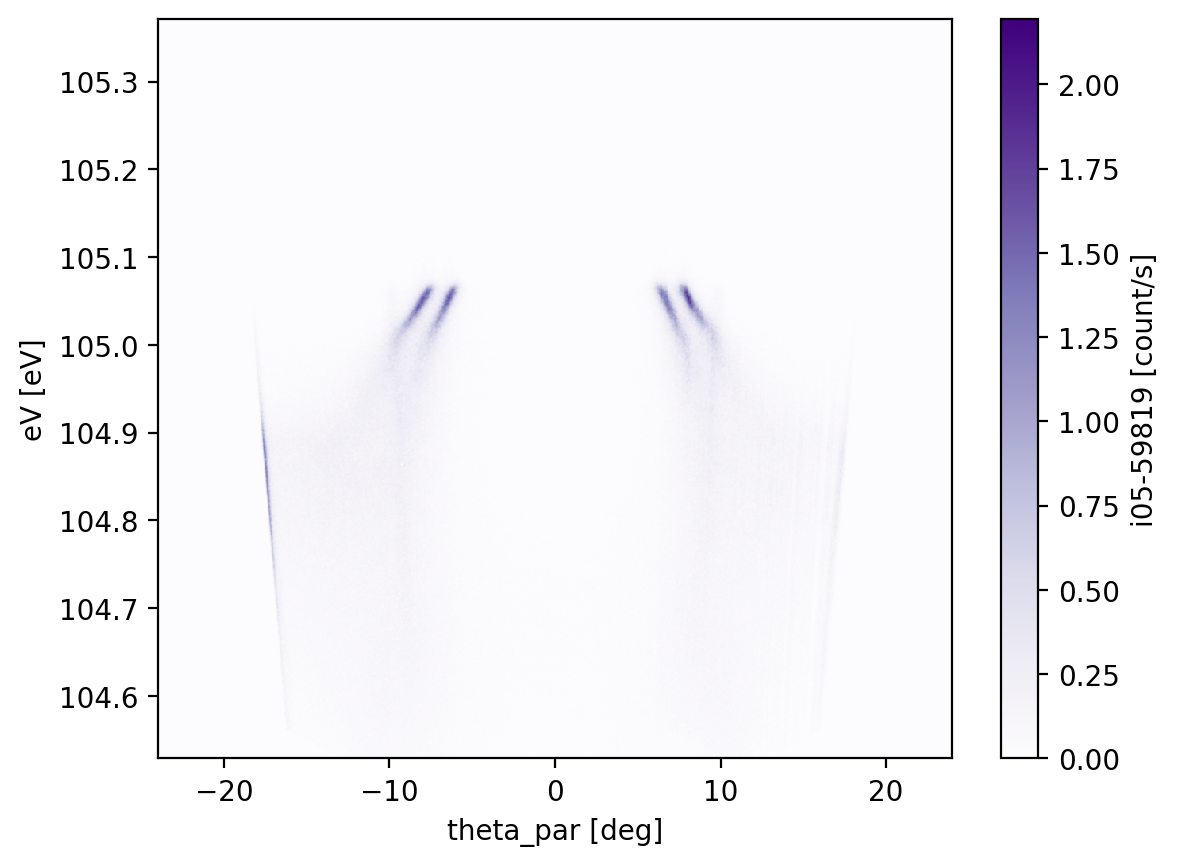

In [4]:
# Load a dispersion
disp = pks.load('i05-59819.nxs')
disp.plot()

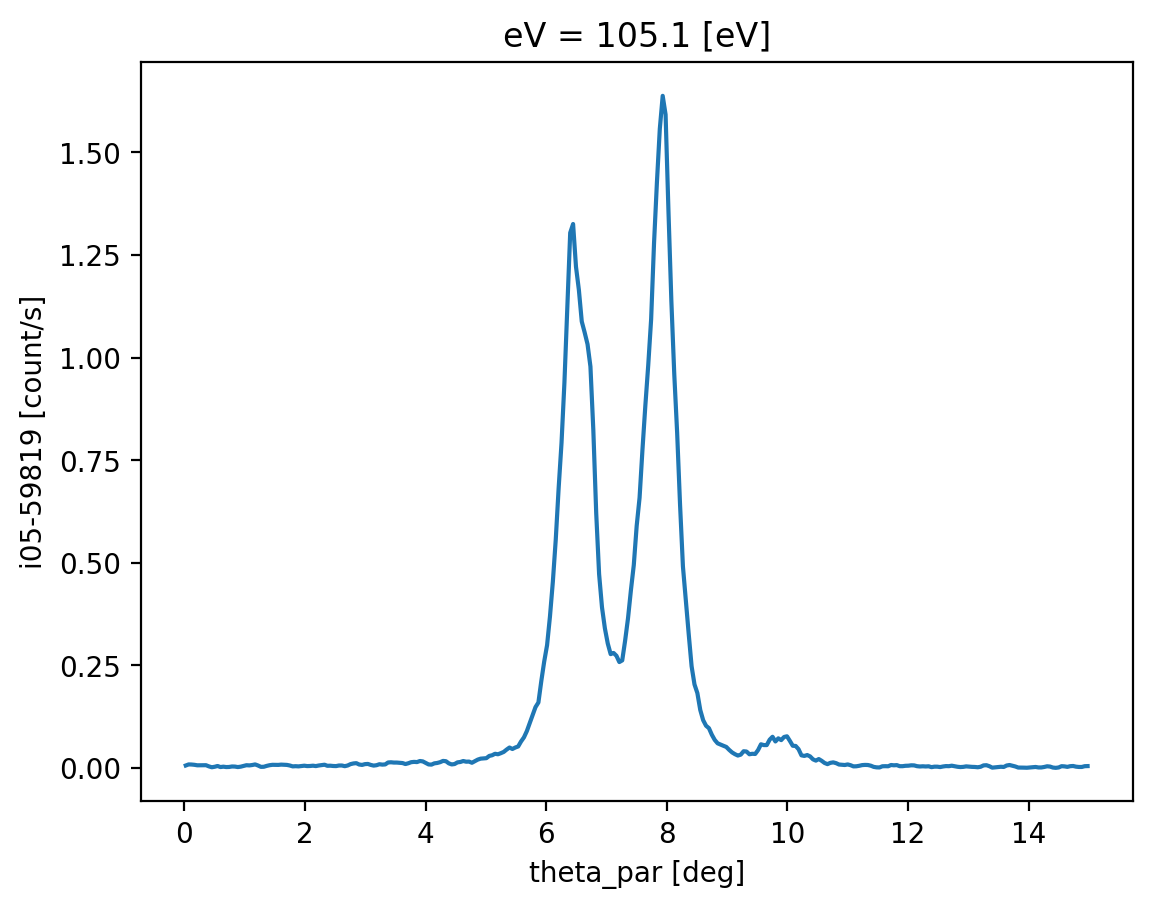

In [5]:
# Extract an MDC for initial analysis
cut1 = disp.MDC(105.06, 0.005).sel(theta_par=slice(0,15))#.pint.dequantify()
cut1.plot()

We'll fit this with the following model:

- 3 Lorentzian peaks
- Linear background
- Convolve with a Gaussian for experimental angular resolution

First we import the relevant base peak models and a model for performing the Gaussian convolution

In [6]:
from peaks.core.fitting.models import LorentzianModel, LinearModel, GaussianConvolvedFitModel, ConstantModel

Now we build the model and initialise the parameters. The initial model is built using the `peaks`-wrapped versions of the standard models combined with binary operators (forming a :class:`lmfit.model.CompositeModel`), and then this is passed to the :function:`peaks.core.fitting.models.GaussianConvolvedFitModel` to add the Gaussian convolution.

In [7]:
# Build the model
base_model = LinearModel(prefix="bg_")
for i in range(3):
    base_model += LorentzianModel(prefix=f"p{i}_")
model = GaussianConvolvedFitModel(base_model)

# Make the fit parameter list
params = model.make_params()

In [8]:
# Show all the parameters
params

name,value,initial value,min,max,vary,expression
bg_slope,1.00000000,None,-inf,inf,True,
bg_intercept,0.00000000,None,-inf,inf,True,
p0_amplitude,1.00000000,None,-inf,inf,True,
p0_center,0.00000000,None,-inf,inf,True,
p0_sigma,1.00000000,None,0.00000000,inf,True,
p1_amplitude,1.00000000,None,-inf,inf,True,
p1_center,0.00000000,None,-inf,inf,True,
p1_sigma,1.00000000,None,0.00000000,inf,True,
p2_amplitude,1.00000000,None,-inf,inf,True,
p2_center,0.00000000,None,-inf,inf,True,


We can manually enter sensible starting parameters, e.g.:

In [9]:
params = model.make_params(sigma_conv=dict(value=0.1, vary=False))  # e.g. fix the resolution 

In [10]:
params

name,value,initial value,min,max,vary,expression
bg_slope,1.00000000,None,-inf,inf,True,
bg_intercept,0.00000000,None,-inf,inf,True,
p0_amplitude,1.00000000,None,-inf,inf,True,
p0_center,0.00000000,None,-inf,inf,True,
p0_sigma,1.00000000,None,0.00000000,inf,True,
p1_amplitude,1.00000000,None,-inf,inf,True,
p1_center,0.00000000,None,-inf,inf,True,
p1_sigma,1.00000000,None,0.00000000,inf,True,
p2_amplitude,1.00000000,None,-inf,inf,True,
p2_center,0.00000000,None,-inf,inf,True,


Or we can make use of the estimating capabilities of the individual models. This is not implemeted for all models, but is for most. It also does not work for the complete composite model in one go, and so we iterate through each peak and component in turn...

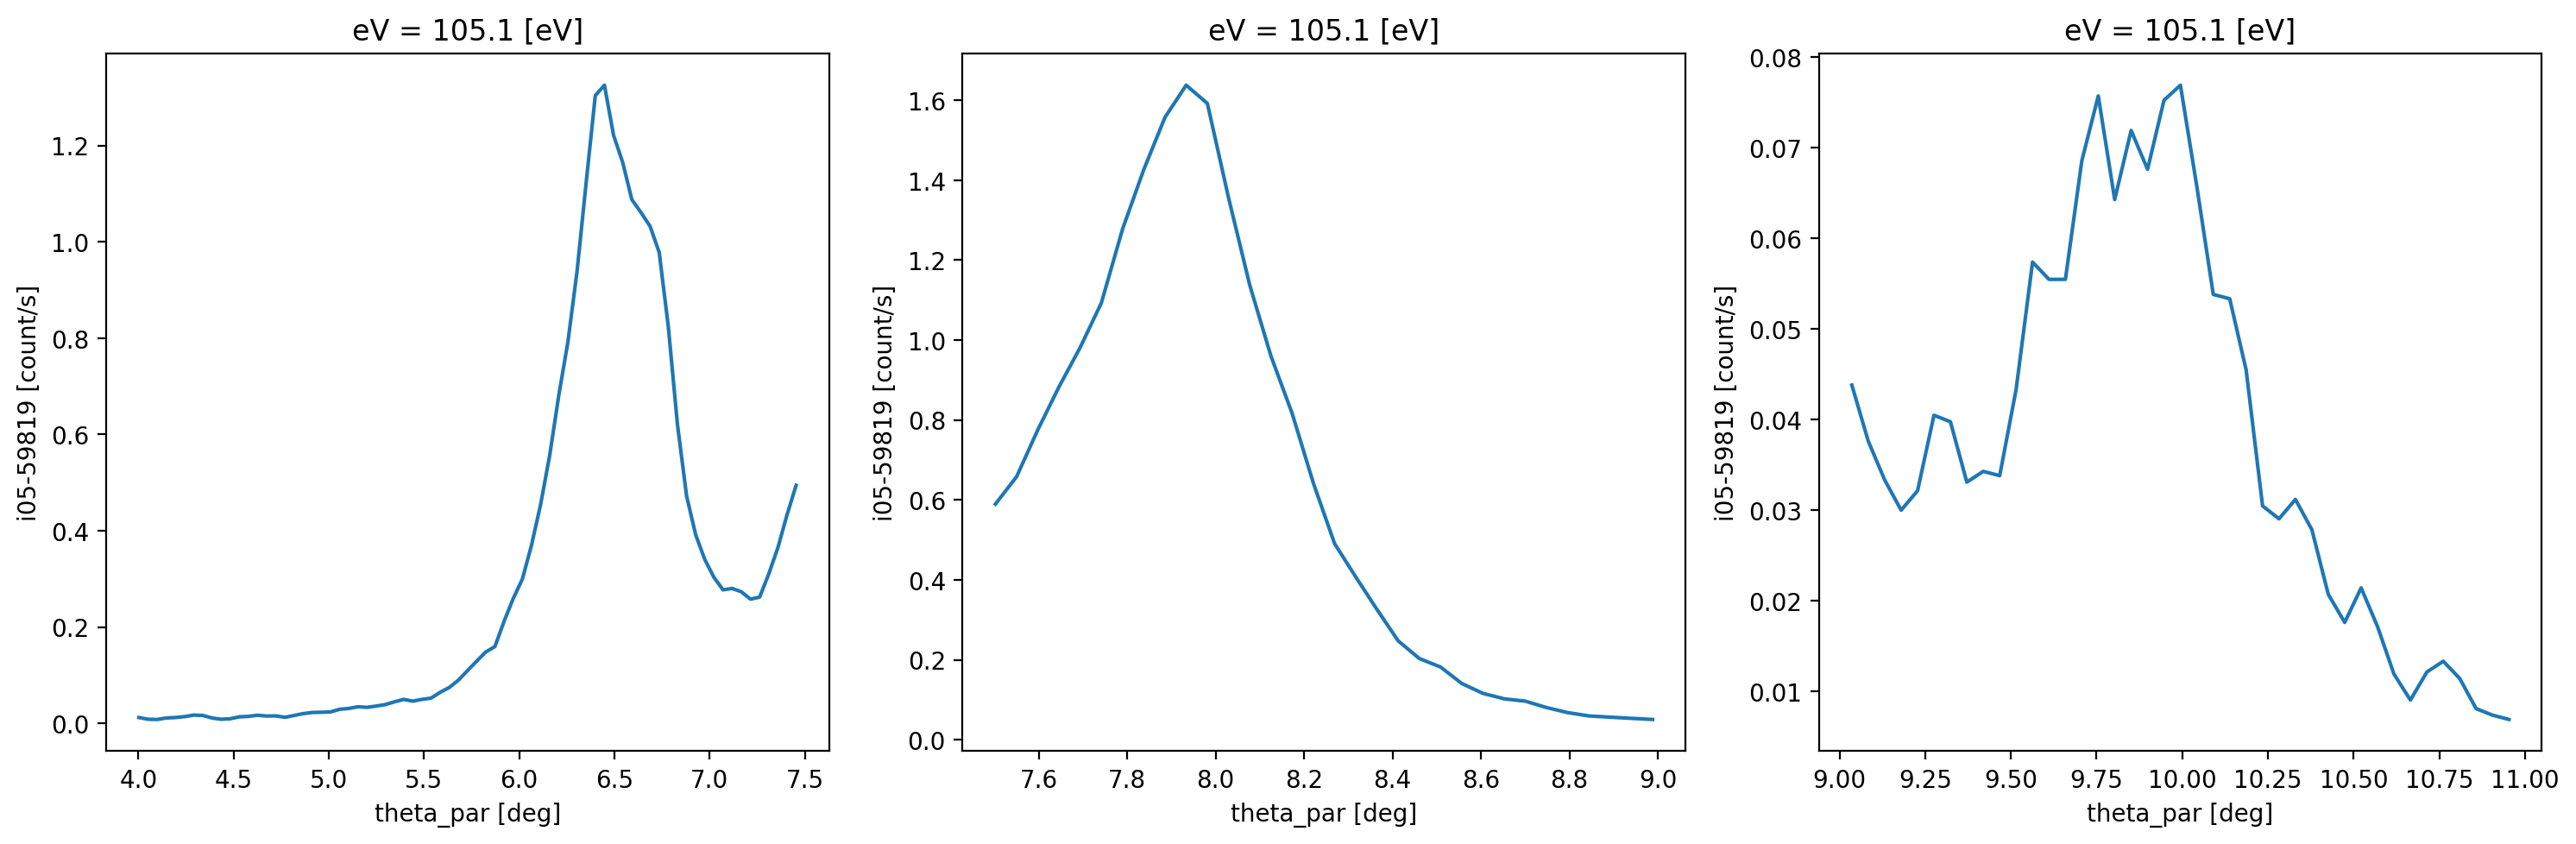

In [12]:
# Estimate theta_par ranges for the peaks
p_range = {}
p_range[0] = [4,7.5]
p_range[1] = [7.5,9]
p_range[2] = [9,11]
pks.plot_grid([cut1.sel(theta_par=slice(p_range[i][0],p_range[i][1])) for i in range(3)])

In [13]:
# Estimate fit parameters over these ranges
for i in range(3):
    t1,t2 = p_range[i]
    DC_data = cut1.sel(theta_par=slice(t1,t2))  # Select data over this range
    # With the `peaks` wrapped fit models, we pass the 1D DataArray directly instead of seperate y and x values
    peak_param_guess = LorentzianModel(prefix=f"p{i}_").guess(DC_data)  # Guess the initial params
    # Iterate through the guessed params and update the main params dictionary
    params.update(peak_param_guess)

# Make a guess for the background from the start of the range
DC_data = cut1.sel(theta_par=slice(0,4))
bg_param_guess = LinearModel(prefix="bg_").guess(DC_data)
params.update(bg_param_guess)

# Show updated params
params

name,value,initial value,min,max,vary,expression
bg_slope,0.00208085,0.0020808476700667324,-inf,inf,True,
bg_intercept,0.00273084,0.00273084139153561,-inf,inf,True,
p0_amplitude,1.42112268,1.4211226845298488,-inf,inf,True,
p0_center,6.49528929,6.4952892857142865,-inf,inf,True,
p0_sigma,0.28761429,0.2876142857142856,0.00000000,inf,True,
p1_amplitude,1.42630157,1.4263015721951224,-inf,inf,True,
p1_center,7.88542500,7.885424999999999,-inf,inf,True,
p1_sigma,0.23967857,0.23967857142857163,0.00000000,inf,True,
p2_amplitude,0.15099751,0.1509975060001015,-inf,inf,True,
p2_center,9.79985759,9.799857589285715,-inf,inf,True,


We can plot the calcuated model using our guessed parameters on top of our data

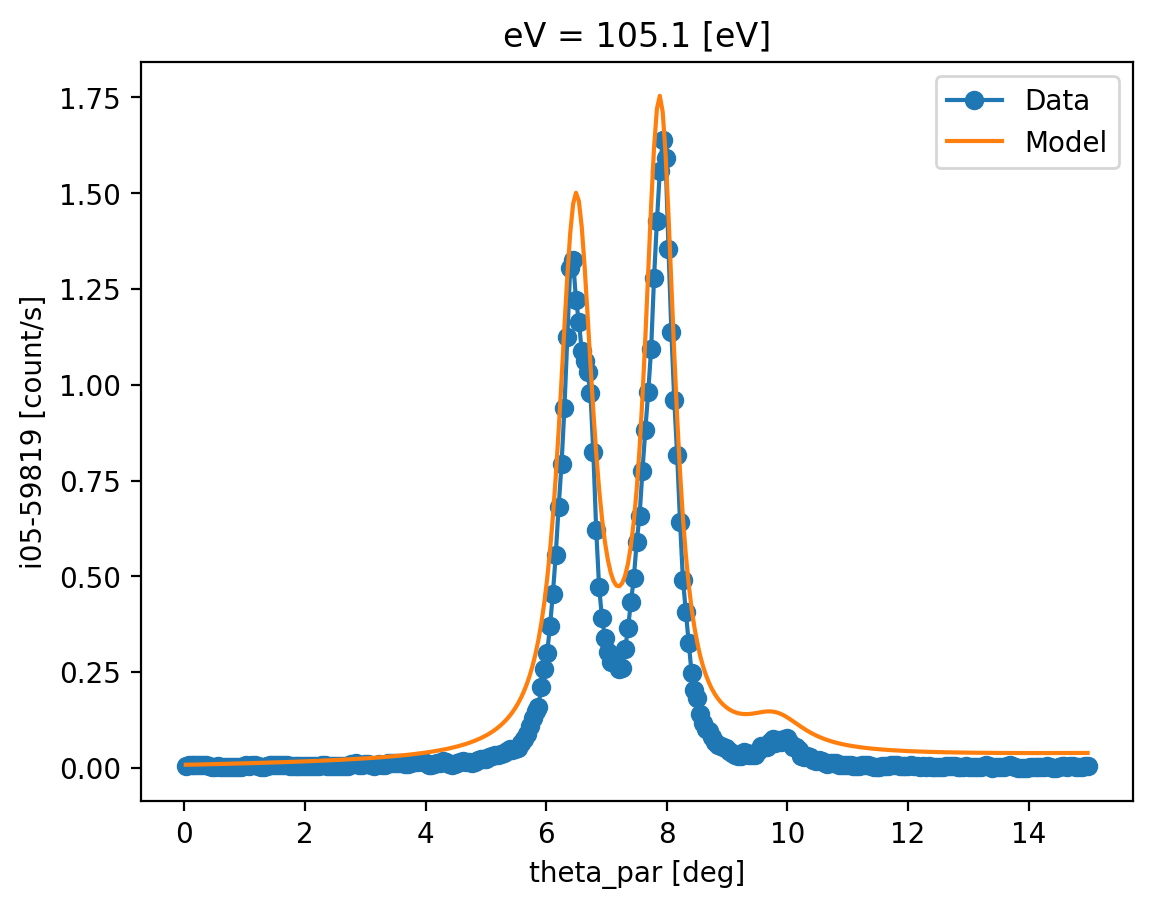

In [14]:
cut1.plot_fit_test(model=model, params=params, show_components=False)

This looks a reasonable starting point, so we can now fit the model. For this, we can make use of the :class:`peaks.core.fitting.fit` method, passing the data as an :class:`xarray.DataArray`. As this is a 1D DataArray, we do not need to explicitly specify the independent dimension (but we would if we had passed a higher dimensional array).

In [15]:
fit_result = cut1.fit(model, params)

This returns a :class:`xarray.DataSet` which contains the results of the fit and standard errors as variables, as well as the full :class:`lmfit.model.ModelResult`.

In [16]:
fit_result

<xarray.Dataset> Size: 304B
Dimensions:              ()
Coordinates:
    eV                   float64 8B 105.1
Data variables: (12/37)
    bg_slope             float64 8B -4.478e-07
    bg_intercept         float64 8B -0.00757
    p0_amplitude         float64 8B 1.087
    p0_center            float64 8B 6.495
    p0_sigma             float64 8B 0.2367
    p1_amplitude         float64 8B 1.179
    ...                   ...
    p0_height_stderr     float64 8B 0.01841
    p1_fwhm_stderr       float64 8B 0.007197
    p1_height_stderr     float64 8B 0.02117
    p2_fwhm_stderr       float64 8B 0.1643
    p2_height_stderr     float64 8B 0.02816
    fit_model            object 8B <lmfit.model.ModelResult object at 0x16230...
Attributes: (1)

In [17]:
# Full lmfit ModelResult
fit_result['fit_model'].values[()]

#### Plotting fits
The fit, components and residual can be plot using the method `.plot_fit()`

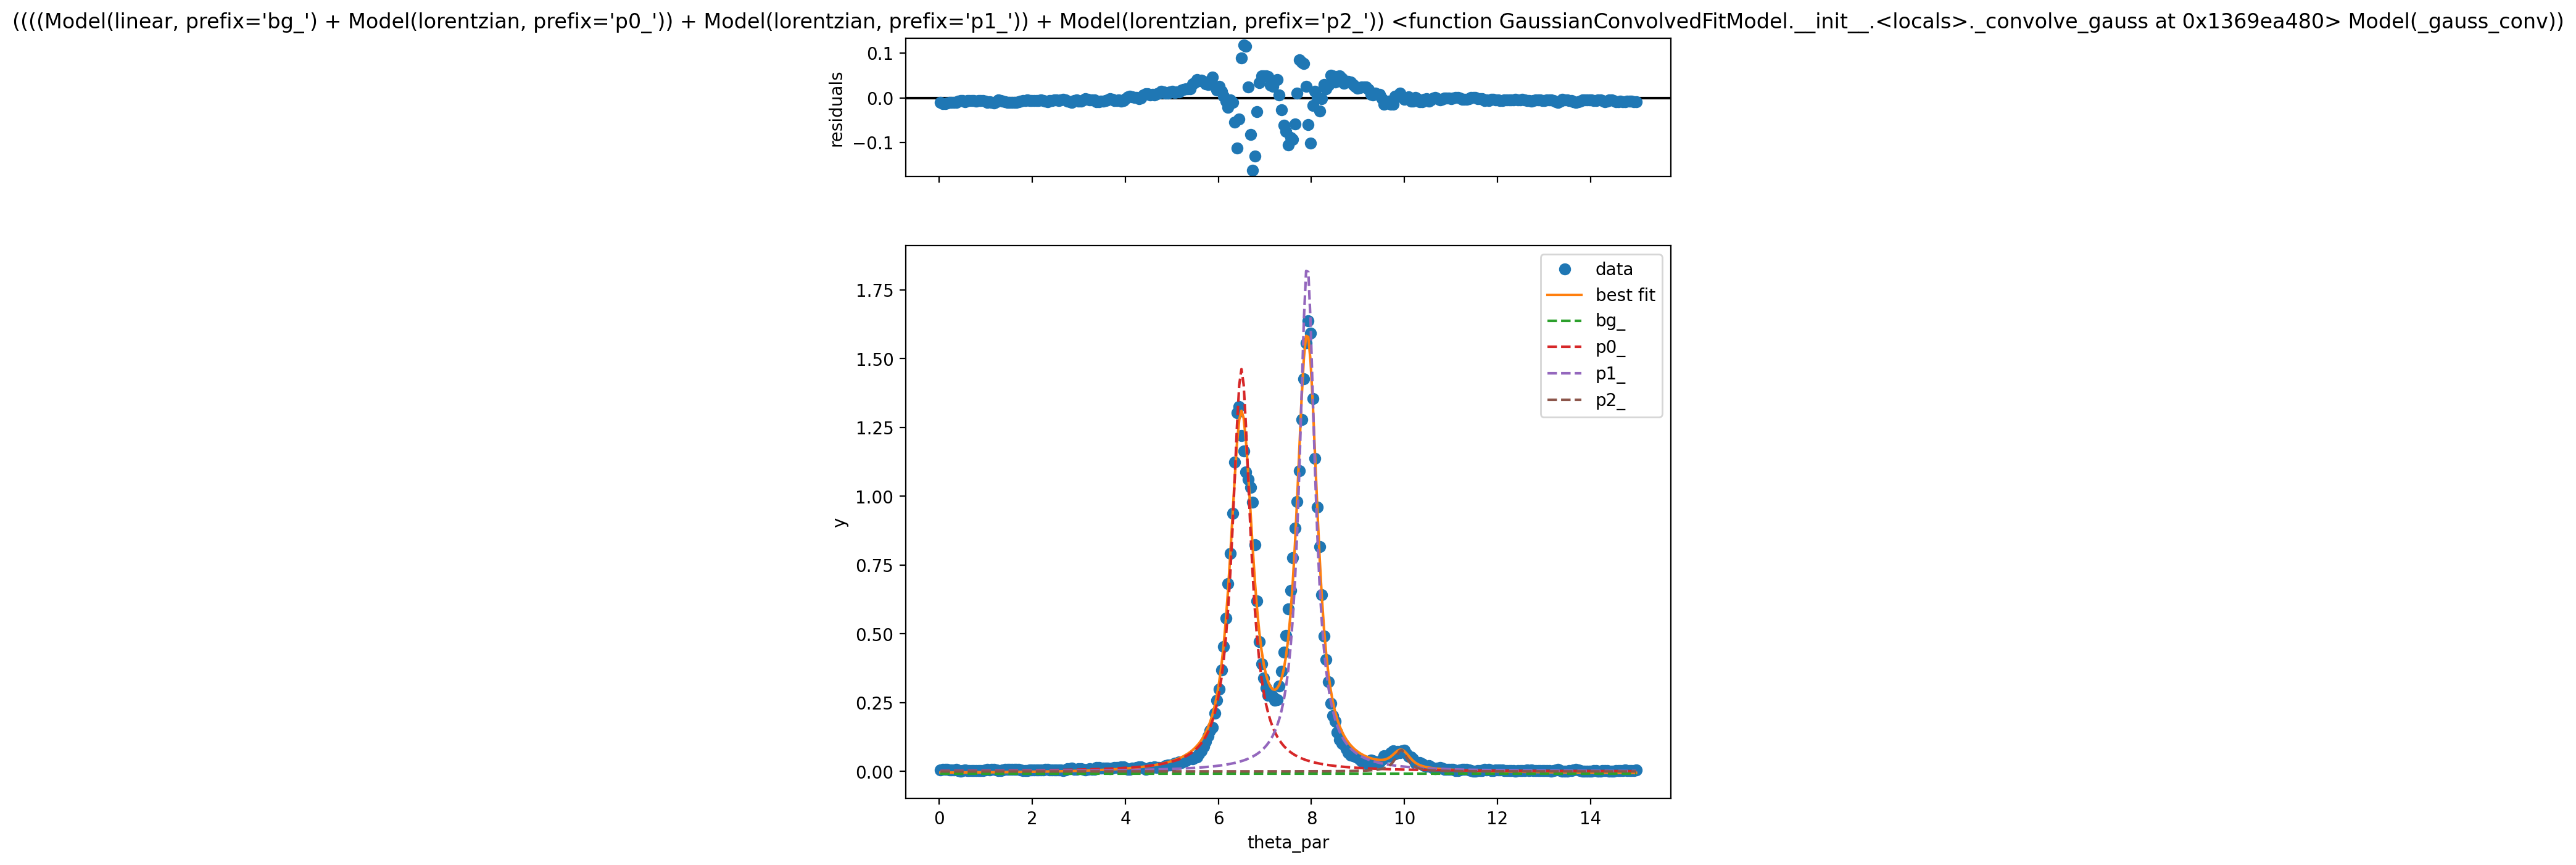

In [18]:
fit_result.plot_fit(figsize=(8,8))

#### Saving and loading fits
We can save the fit results (including the full model) and recover them using the `.save_fit` and `.load_fit` methods:

In [19]:
fit_result.save_fit('fit_example')
previous_fit_result = pks.load_fit('fit_example')
if previous_fit_result == fit_result:
    print(True)

True


## Fitting multi-dimensional data
We'll now fit a series of MDCs from this dataset. We can either simply select the data over the required range we wish to fit, or for more complex fit regions, can mask the data:

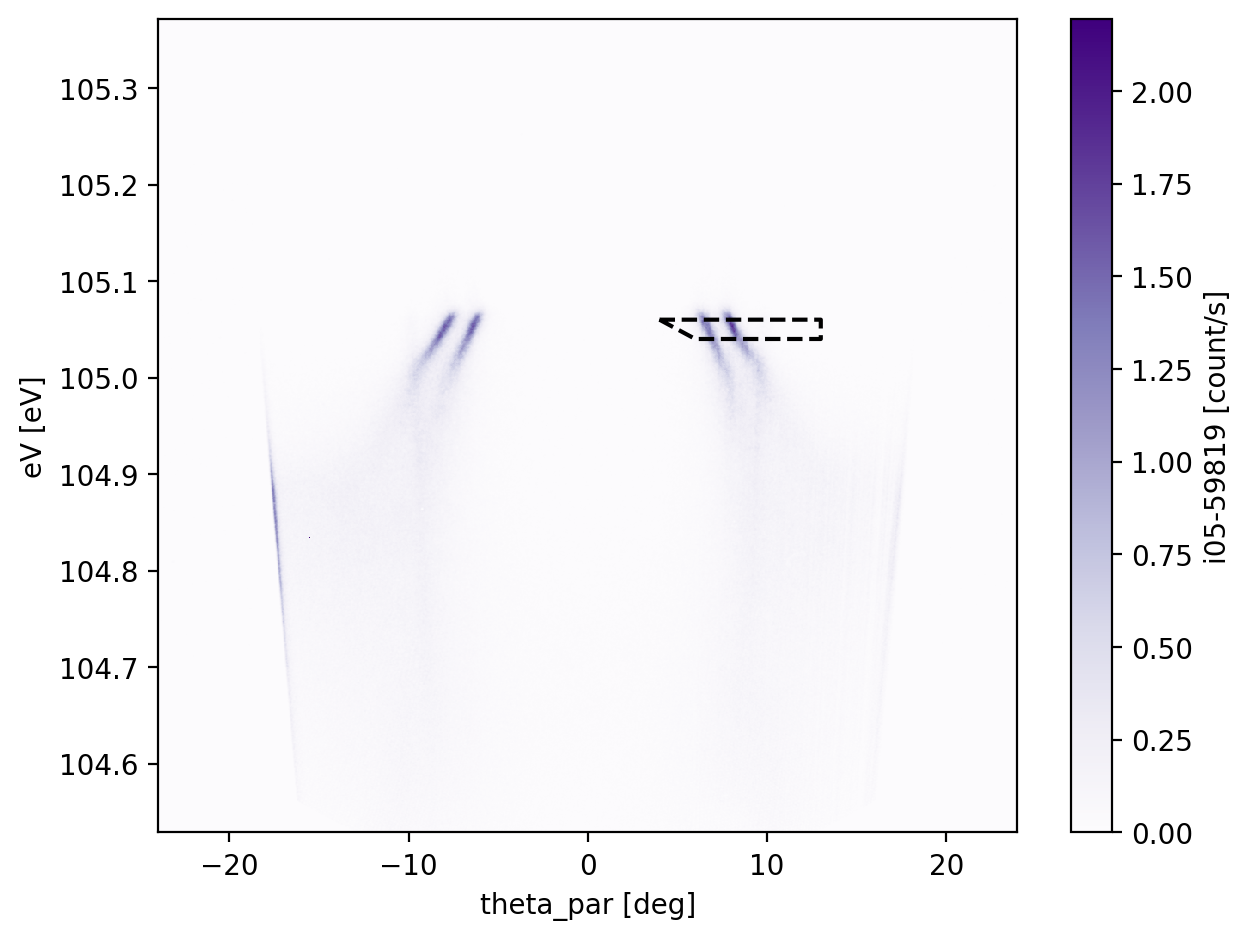

In [20]:
disp.plot()
# Define a custom mask region
mask_region = {'eV': [105.06, 105.04, 105.04, 105.06],
              'theta_par': [4, 6, 13, 13]}
# Note - choosing this region for illustration of the method, not because it is a particularly sensible region to fit over...!

# Plot the mask
pks.plot_ROI(mask_region, y='eV', linestyle='--')

# Select the data
data_to_fit = disp.mask_data(mask_region, return_integrated=False)

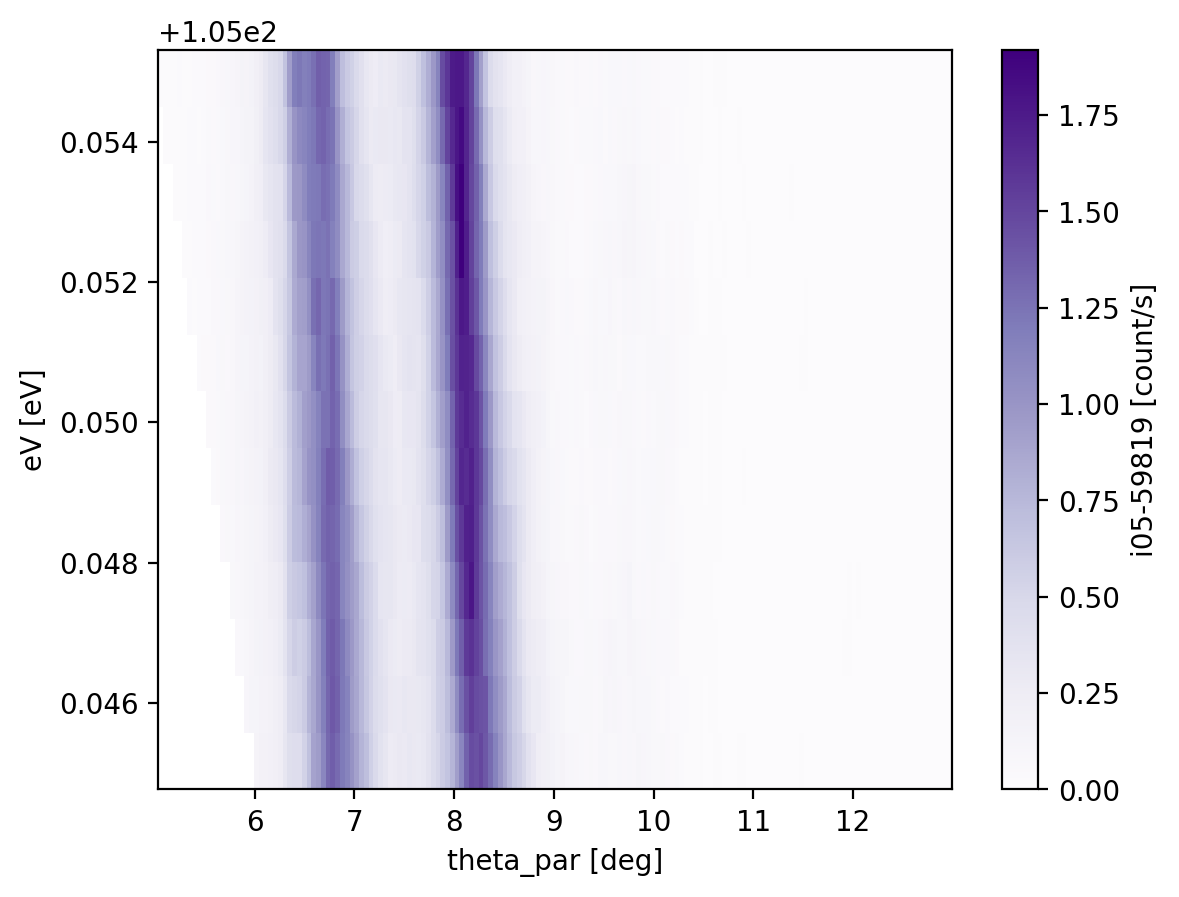

In [21]:
data_to_fit.plot()

In [22]:
data_to_fit

Magnitude,[[nan nan nan ... 0.0016666667070239782 0.004999999888241291 0.004999999888241291] [nan nan nan ... 0.0033333334140479565 0.0033333334140479565 0.0] [nan nan nan ... 0.0016666667070239782 0.0 0.0016666667070239782] ... [nan nan nan ... 0.009999999776482582 0.008333333767950535 0.008333333767950535] [nan 0.019999999552965164 0.021666666492819786 ... 0.0033333334140479565 0.0033333334140479565 0.0033333334140479565] [0.02500000037252903 0.02666666731238365 0.028333334252238274 ... 0.0016666667070239782 0.0 0.0016666667070239782]]
Units,count/s


As we have now masked the data in a way that leaves NaNs at the edges for some of the data sets, we need to ensure the fit model can cope with this. To do this, we set the model `nan_policy`:

In [23]:
model.nan_policy = 'omit'

For a 2D DataArray like this, we can choose to fit the data sequentially, where the result from the previous fit is used to initiate the starting parameters of the next fit, or using the same starting parameters for all fits (the latter also allows fitting the data using parallel processing). We will use the sequential mode here, which is the default when we are fitting 2D data.  

In [24]:
# Fit the data - note we have reversed the direction in which to perform the sequential fit as we 
# figured out our initial guess parameters for the `last` MDC in this DataArray
%time fit_result2 = data_to_fit.fit(model, params, independent_var='theta_par', reverse_sequential_fit_order = True)

Fitting:   0%|          | 0/13 [00:00<?, ?it/s]

CPU times: user 301 ms, sys: 7.34 ms, total: 309 ms
Wall time: 307 ms


We can now plot the relevant results of the fit directly from the returned dataset.

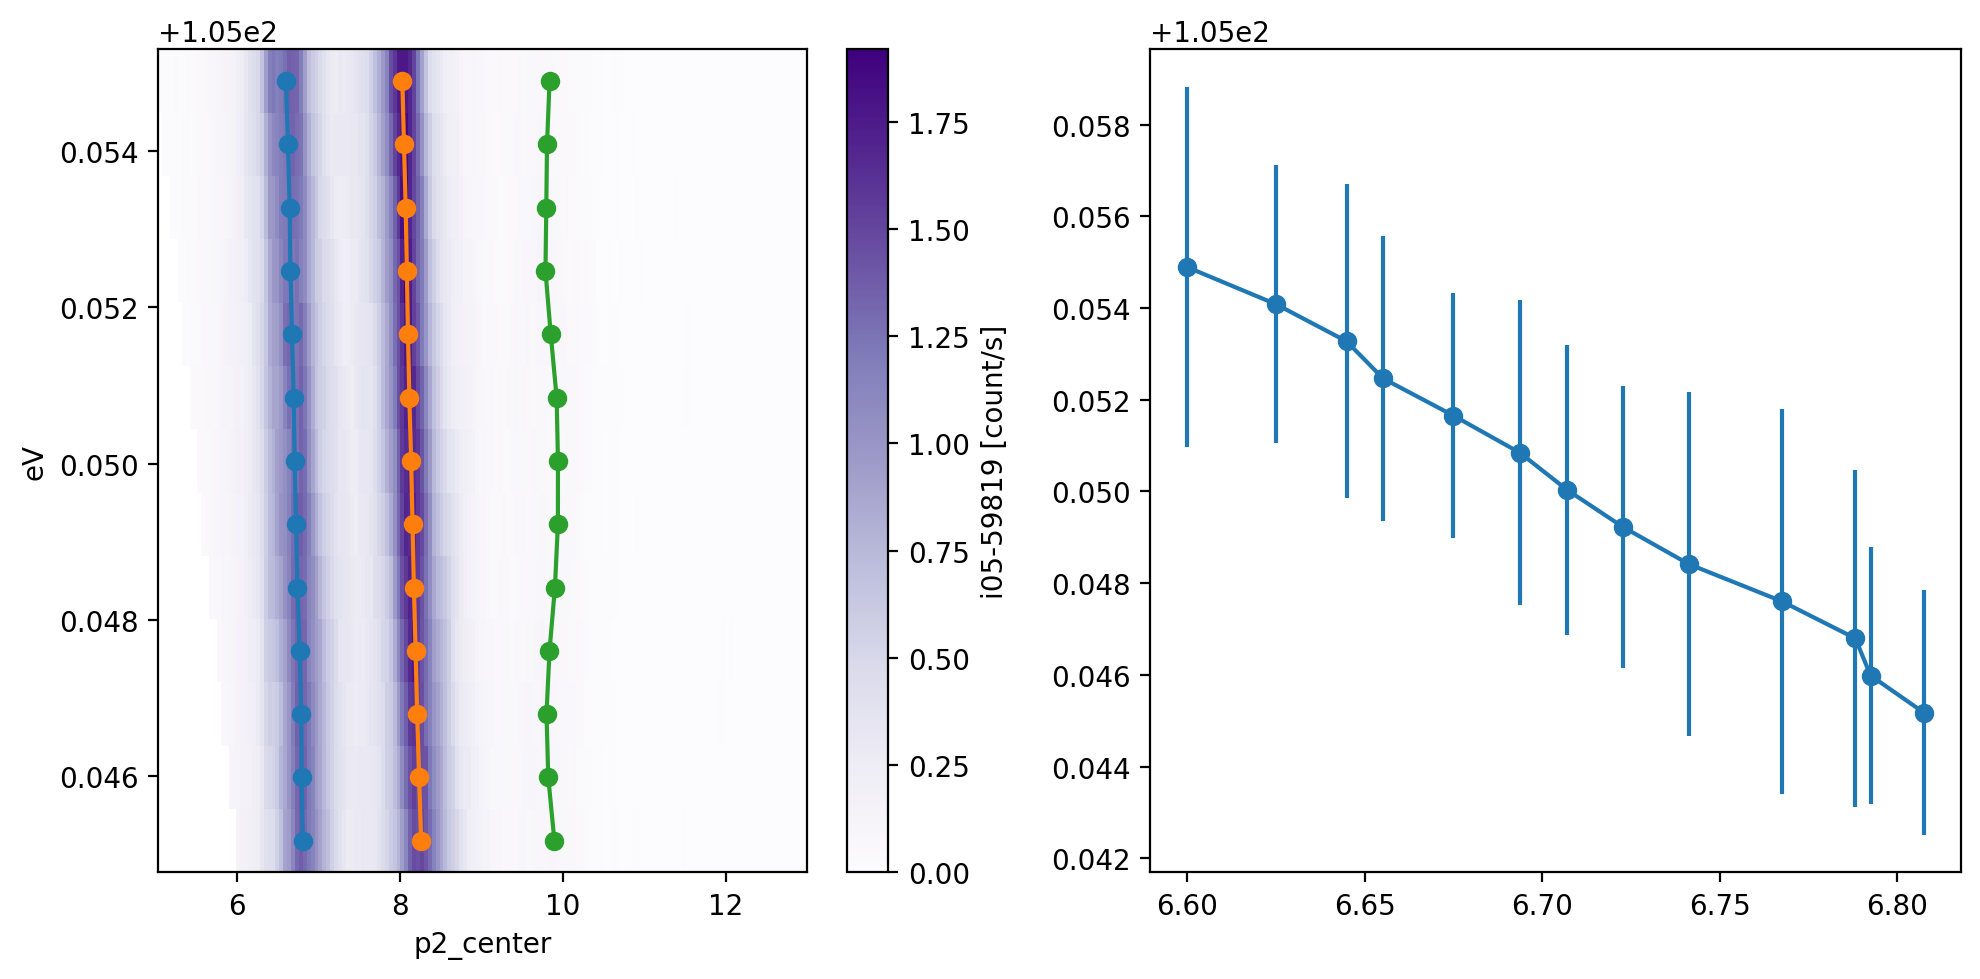

In [25]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
data_to_fit.plot(ax=ax[0])
fit_result2['p0_center'].plot(ax=ax[0], y='eV', marker='o')
fit_result2['p1_center'].plot(ax=ax[0], y='eV', marker='o')
fit_result2['p2_center'].plot(ax=ax[0], y='eV', marker='o')

# Plot the fit with the error bars
ax[1].errorbar(x=fit_result2['p0_center'].data,
           y=fit_result2['p0_center'].eV.data,
           yerr=fit_result2['p0_center_stderr'].data,
        marker='o')

plt.tight_layout()

Calling the `plot_fit()` function on the fit result will now allow us to dynamically explore the fits and their residuals

Column
    [0] Row
        [0] IntSlider(end=12, name='eV')
    [1] Matplotlib(Figure)
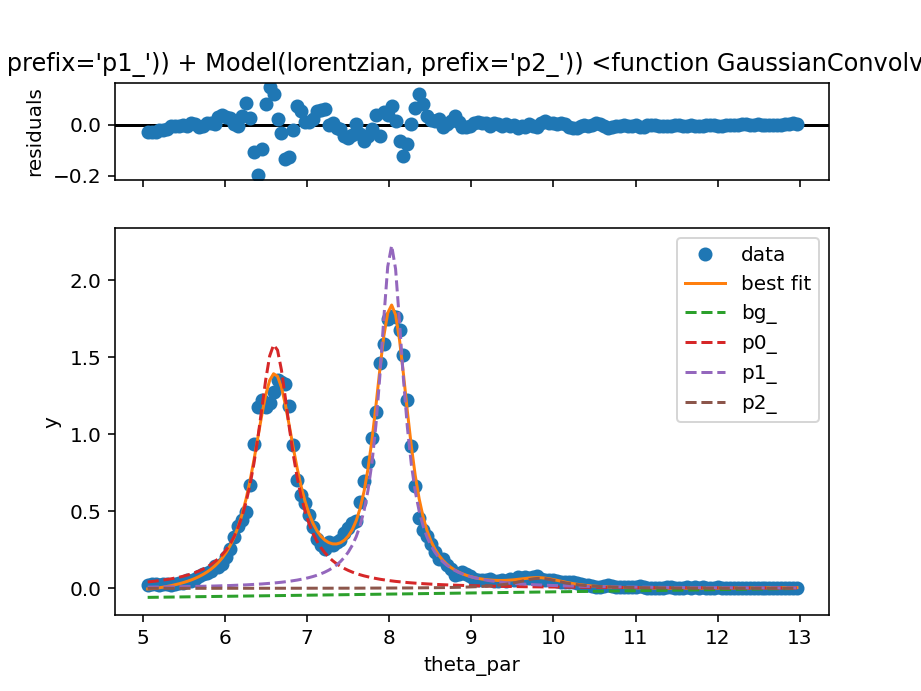

In [26]:
fit_result2.plot_fit()

### Dask arrays
The above methodology extends naturally to higher-dimensional data sets, although then sequential fitting cannot be used. If fitting higher-dimensional data (and sometimes also for lower-dimensional data), it is worth considering using :class:`dask`-backed :class:`xarray.DataArray`'s. This allows the fit to be performed in parallel, or in a lazy manner so that it is only computed when required. It is worth considering how best to `chunk` the DataArray to optimise for the intended fitting.

Let's load a section of a spatial map:

In [27]:
SM1 = (pks.load('i05-1-24270.nxs')  # File to load
       .isel(x1=slice(8,20),x2=slice(-10,None))  # Select limited spatial range from the map
       .sel(theta_par=slice(0,5),eV=slice(74,76))  # Select limited angle and energy range
       .bin_data(eV=2,theta_par=5)  # Perform binning in angular and energy dims
       .chunk(eV=-1,x1=1,x2=1)  # Ensure only a single chunk of the Dask array along the eV axis, but chunked in x1 and x2 
      )

<div class="alert alert-block alert-info"><b>Loading info: </b> DataArray has been lazily evaluated in the dask format (set lazy=False to load as DataArray in xarray format). Use the .compute() method to load DataArray into RAM in the xarray format, or the .persist() method to instead load DataArray into RAM in the dask format. Note: these operations load all of the data into memory, so large files may require an initial reduction in size through either a slicing or binning operation. </div>

In [28]:
SM1

<xarray.DataArray 'i05-1-24270' (x2: 10, x1: 12, eV: 232, theta_par: 20)> Size: 4MB
dask.array<chunksize=(1, 1, 232, 20), meta=np.ndarray>
Coordinates:
  * x2         (x2) float64 80B 1.876e+03 1.877e+03 ... 1.884e+03 1.885e+03
  * x1         (x1) float64 96B -642.0 -641.0 -640.0 ... -633.0 -632.0 -631.0
  * theta_par  (theta_par) float64 160B 0.1237 0.371 0.6184 ... 4.576 4.823
  * eV         (eV) float64 2kB 74.01 74.01 74.02 74.03 ... 75.98 75.99 76.0
Attributes: (8)

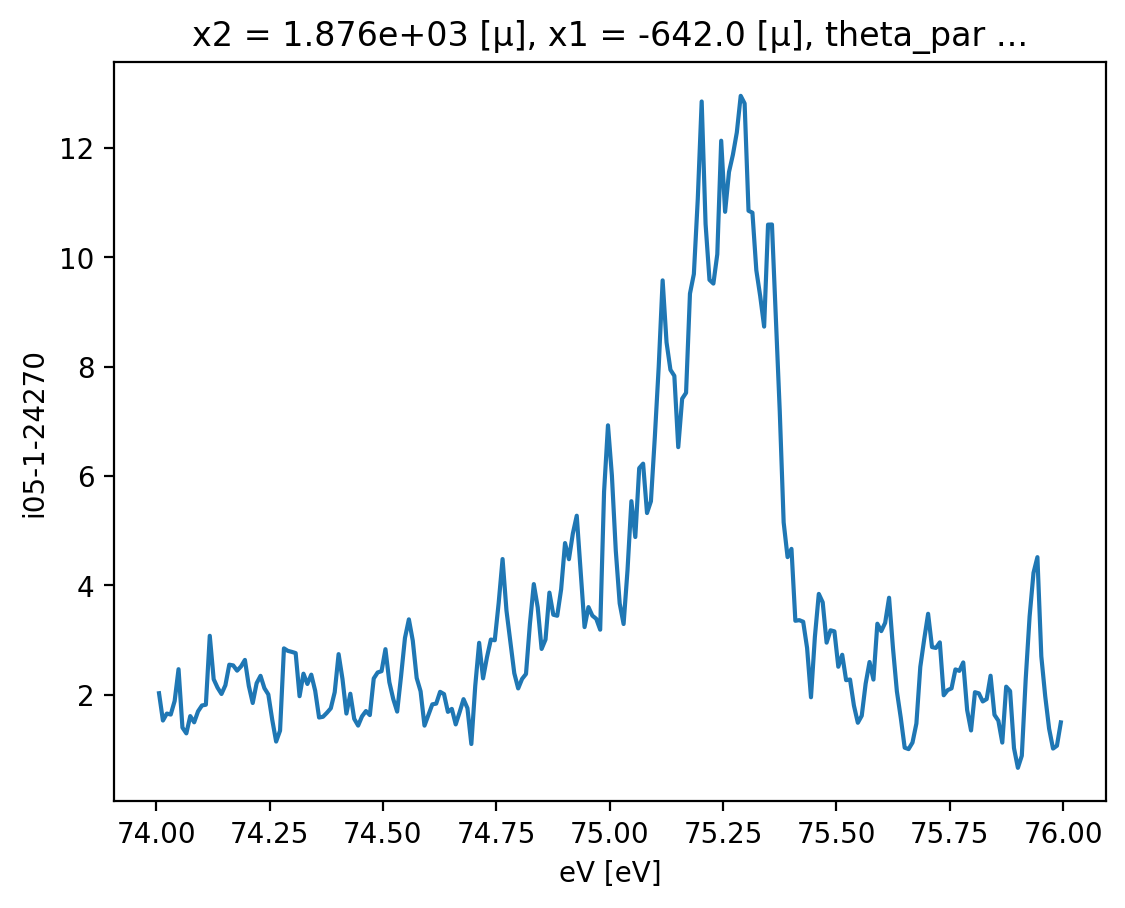

In [29]:
# Extract a single EDC for illustration and setting up the fit
EDC_ = SM1.isel(x1=0,x2=0,theta_par=0)
EDC_.plot()

In [30]:
fit_model = LorentzianModel() + ConstantModel()
params = fit_model.make_params(amplitude=20,
                              center=dict(value=75.25, min=74.5, max=75.7),
                              sigma=0.1,
                              c=dict(value=4, min=0)
                              )

In [31]:
%time fit_results3 = SM1.fit(fit_model, params, independent_var='eV')

<div class="alert alert-block alert-info"><b>Analysis info: </b> Sequential fitting only supported for 2D data. Defaulting to non-sequential. </div>

CPU times: user 20.9 ms, sys: 1.75 ms, total: 22.7 ms
Wall time: 22.7 ms


No fitting has been performed yet (note that this was extremely quick!), but we can still access the fit results plot, with the fits being performed as required

Column
    [0] Row
        [0] IntSlider(end=9, name='x2')
        [1] IntSlider(end=11, name='x1')
        [2] IntSlider(end=19, name='theta_par')
    [1] Matplotlib(Figure)
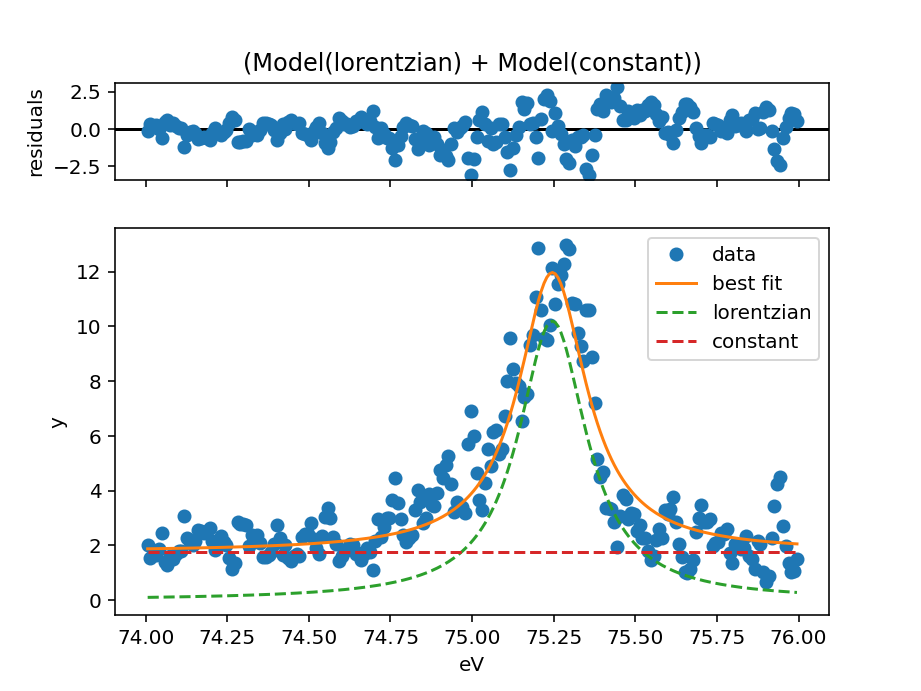

In [32]:
fit_results3.plot_fit()

And we can make plots of relevant fit results

[########################################] | 100% Completed | 10.23 s


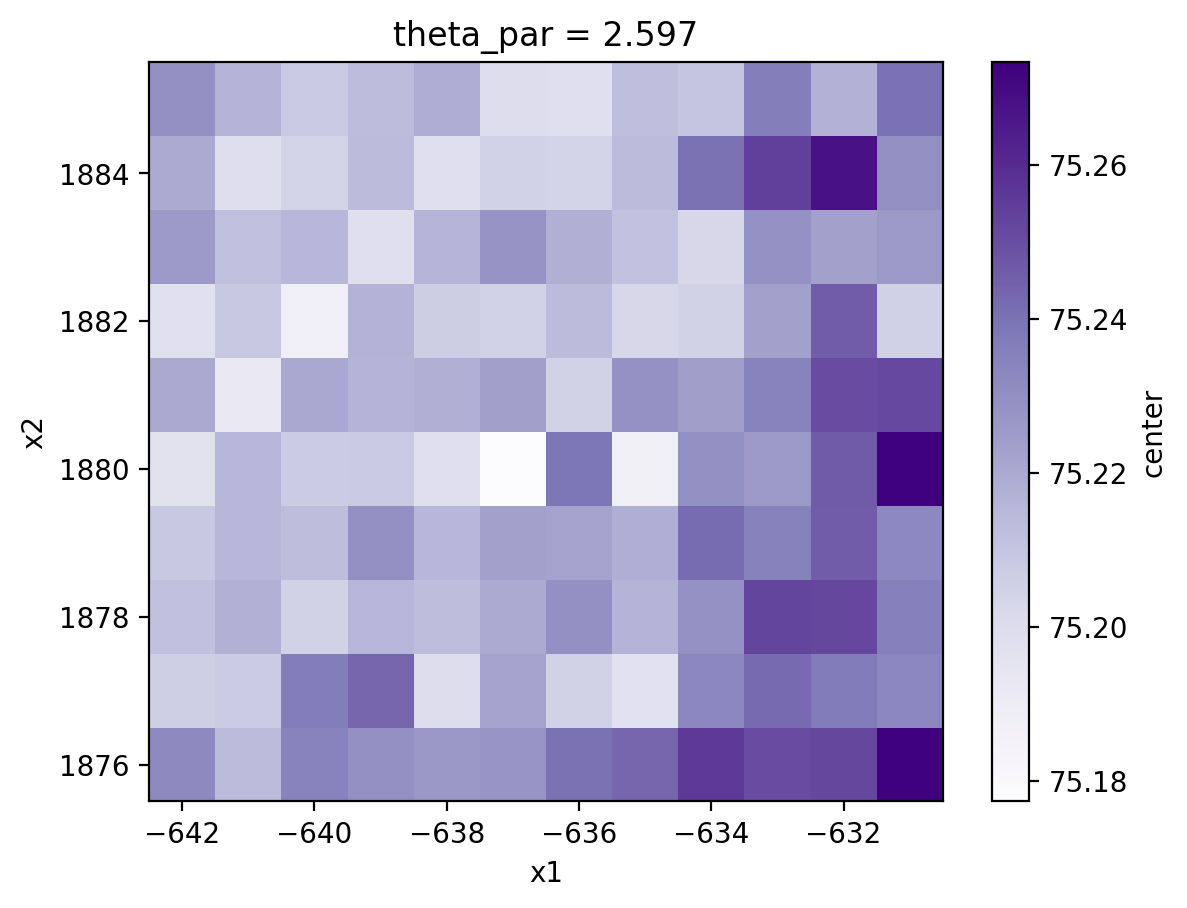

In [33]:
fit_results3['center'].isel(theta_par=10).plot()

## Fitting Au Fermi edge data

For fitting Au Fermi edge data, we employ a model :class:`peaks.core.fitting.LinearDosFermiModel` which employs a linear DOS, and Gaussian-broadened Fermi function, and a linear background above $E_F$ to account for potential detector non-linearities. This model can be imported and manually fit using the methods above, but we also have a utility method `fit_gold` which attempts an automated fitting to this model, and displays some key results as well as returning the actual fit result :class:`xarray.DataSet`.

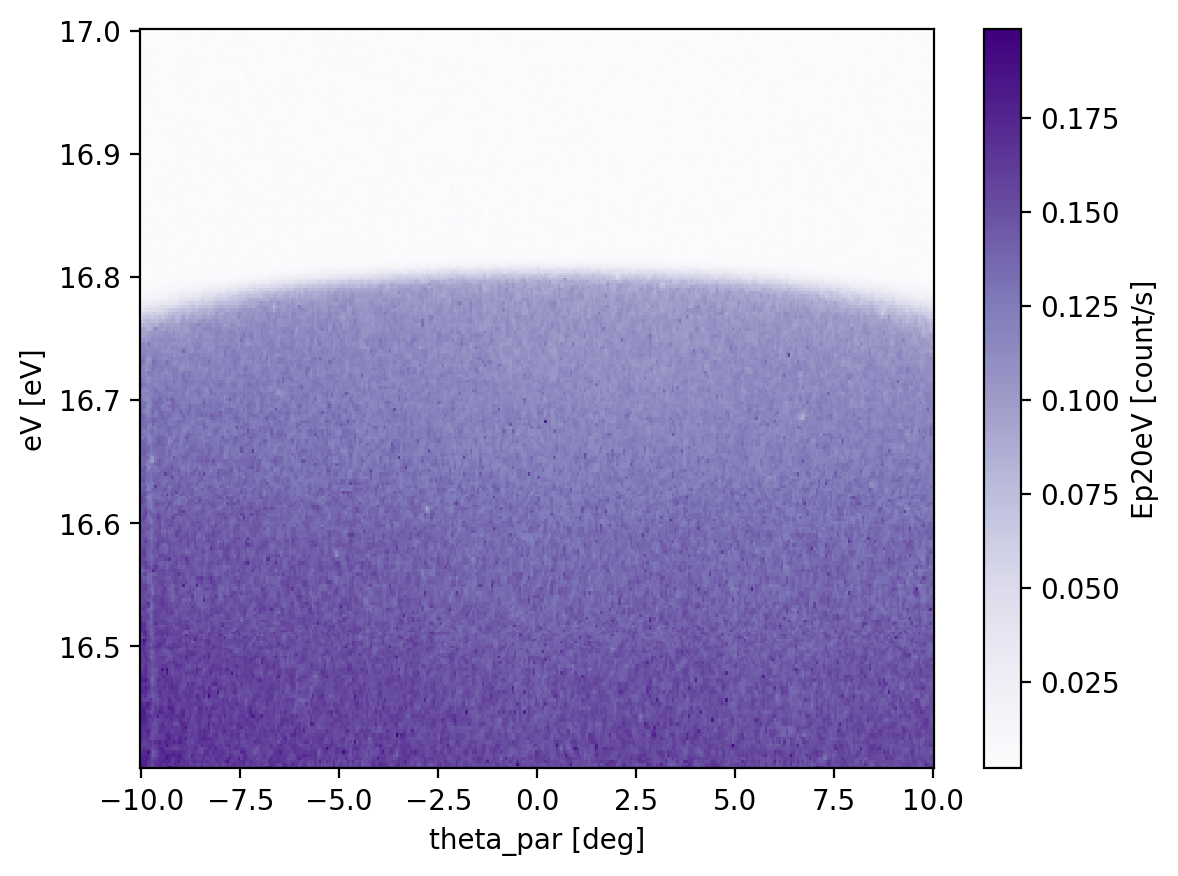

In [34]:
# Load a gold scan and restrict the range to a sensible amount
gold_scan = pks.load('Ep20eV.xy').sel(eV=slice(16.4,17),theta_par=slice(-10,10))
gold_scan.plot()

We can pass a single EDC:

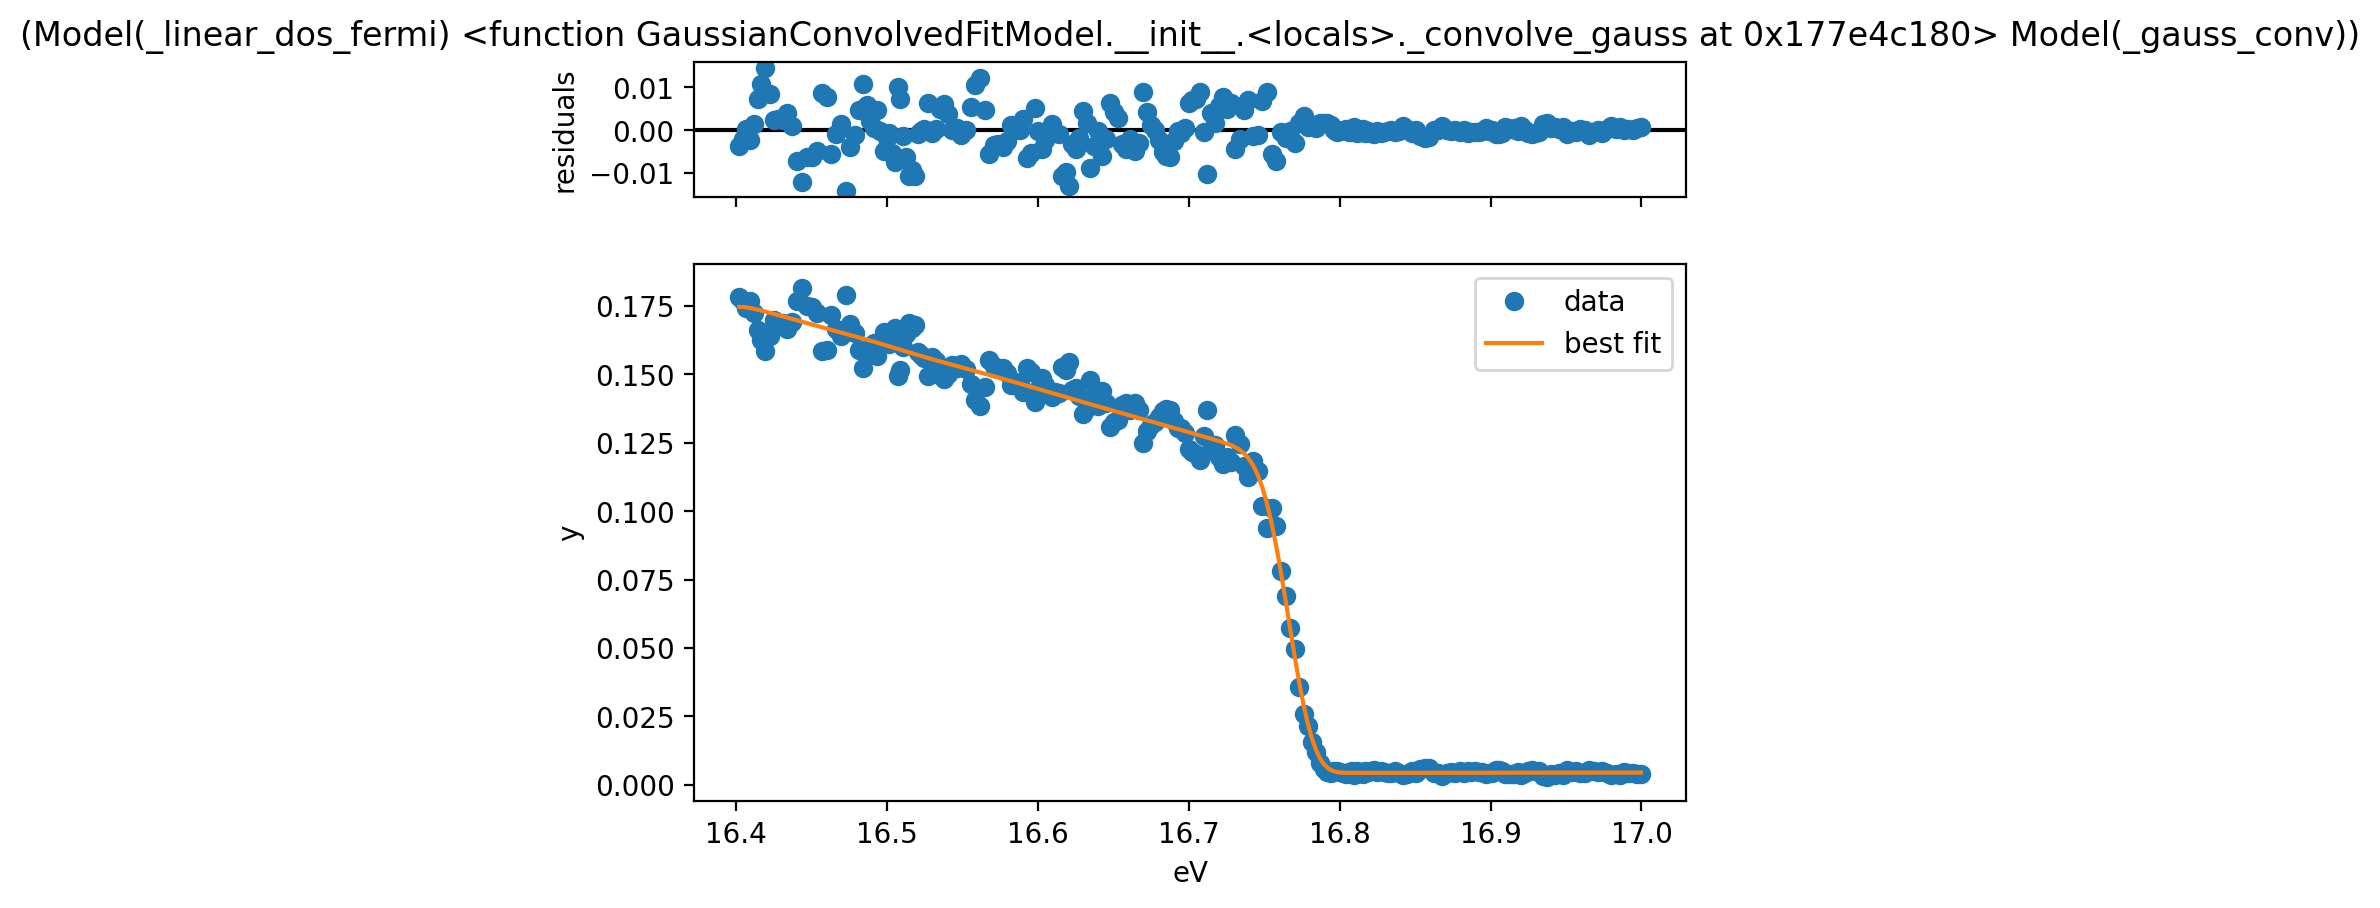

<div class="alert alert-block alert-success"><b>Au fitting results: </b> Fermi energy: 16.766 ± 0.001 eV,  Resolution: 0.011 ± 0.001 eV </div>

In [35]:
fit_result = gold_scan.isel(theta_par=0).fit_gold()

The fitted Fermi energy is also stored in the fit_result attributes

In [36]:
fit_result.attrs

{'independent_var': 'eV', 'EF_correction': 16.76564259404542}

Or we can pass the measured angular-dependent Au reference, optionally specifying the type of function (polynomaial, average etc.) used to determine the Fermi level dependence on detector angle (via the `EF_correction_type` parameter; defaults to polynomail of order 4)

Fitting:   0%|          | 0/342 [00:00<?, ?it/s]

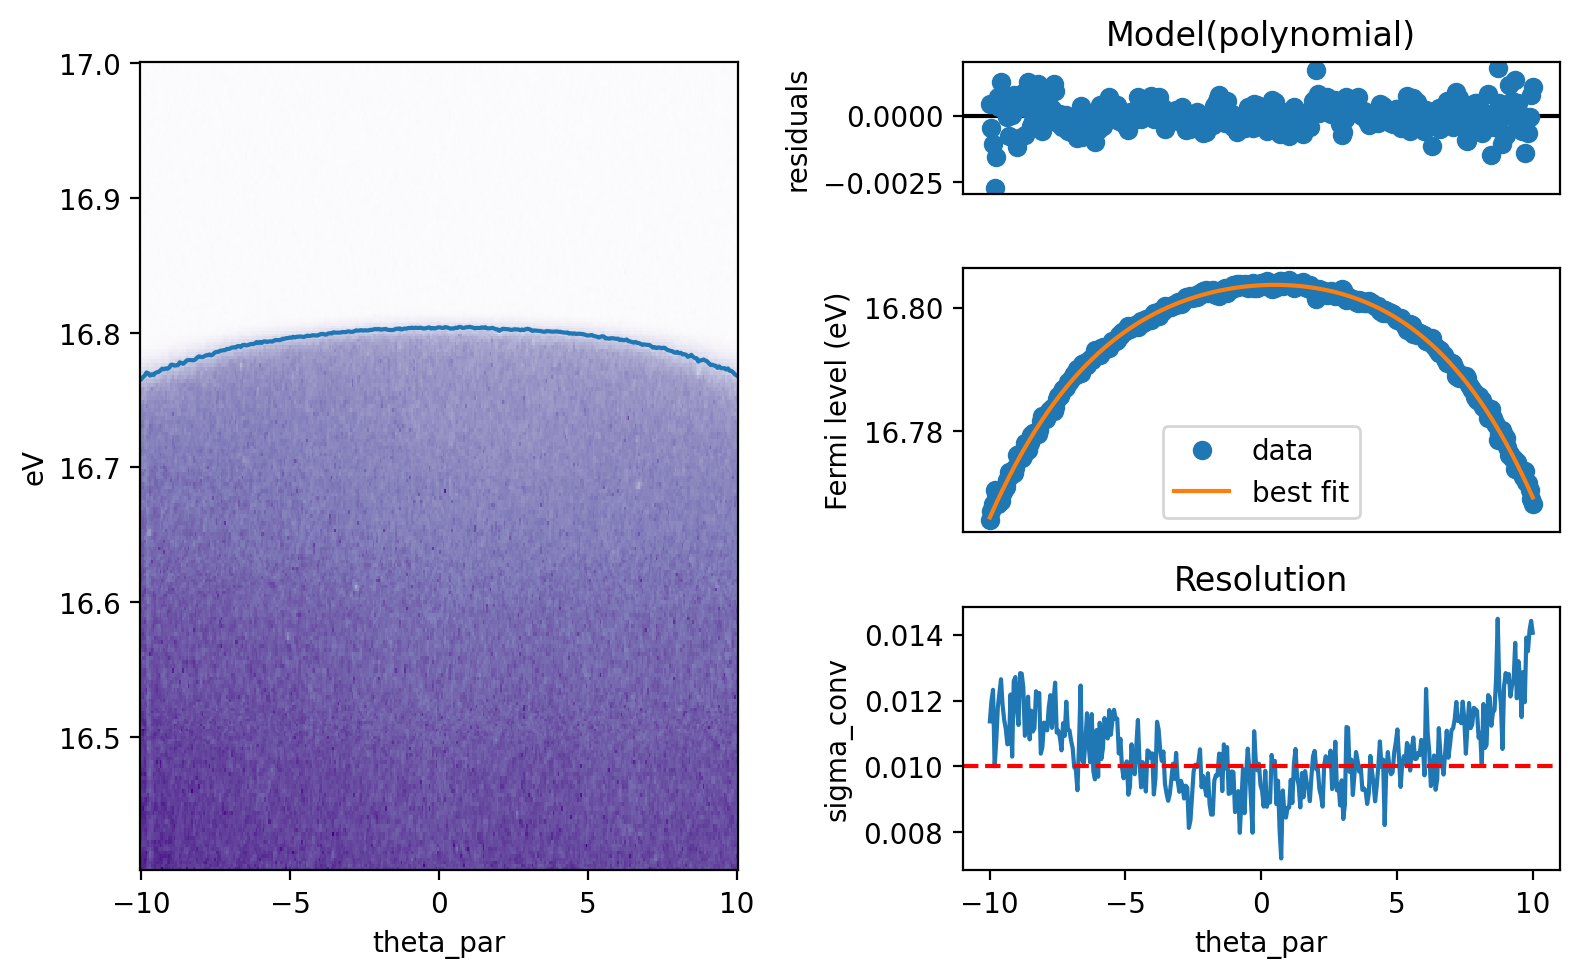

<div class="alert alert-block alert-success"><b>Au fitting results: </b> Polynomial Fermi level correction (order 4): c0: 16.80363, c1: 0.000226, c2: -0.000222, c3: -1e-06, c4: -1e-06;   Average resolution: 0.01 eV </div>

In [37]:
fit_result = gold_scan.fit_gold()

The results of the `EF_correction` fit are stored as a dictionary in the fit results attribute

In [40]:
fit_result.EF_correction


{'c0': 16.803629590690996,
 'c1': 0.00022636527711131392,
 'c2': -0.0002222775821762607,
 'c3': -6.453745309691741e-07,
 'c4': -1.3805270995219083e-06}

## Quick fitting

For simple functions (linear, polynomial of some degree, single peak + linear background), a quite fit can be performed by passing either a 1D DataArray, or a multi-dimensional array and specifying the independent variable. The quick fit is accessed via the `.quick_fit.MODEL` accessor, e.g.:

In [41]:
example_DC = gold_scan.isel(theta_par=0).sel(eV=slice(None, 16.7))

In [42]:
fit_result = example_DC.quick_fit.linear()

This returns the usual `peaks` :class:`xarray.DataSet` fit_result. The parameters can be seen directly: 

In [43]:
fit_result

<xarray.Dataset> Size: 48B
Dimensions:           ()
Coordinates:
    theta_par         float64 8B -9.99
Data variables:
    slope             float64 8B -0.146
    intercept         float64 8B 2.57
    slope_stderr      float64 8B 0.006056
    intercept_stderr  float64 8B 0.1002
    fit_model         object 8B <lmfit.model.ModelResult object at 0x286d64a70>
Attributes: (1)

Or the plot can be returned as usual:

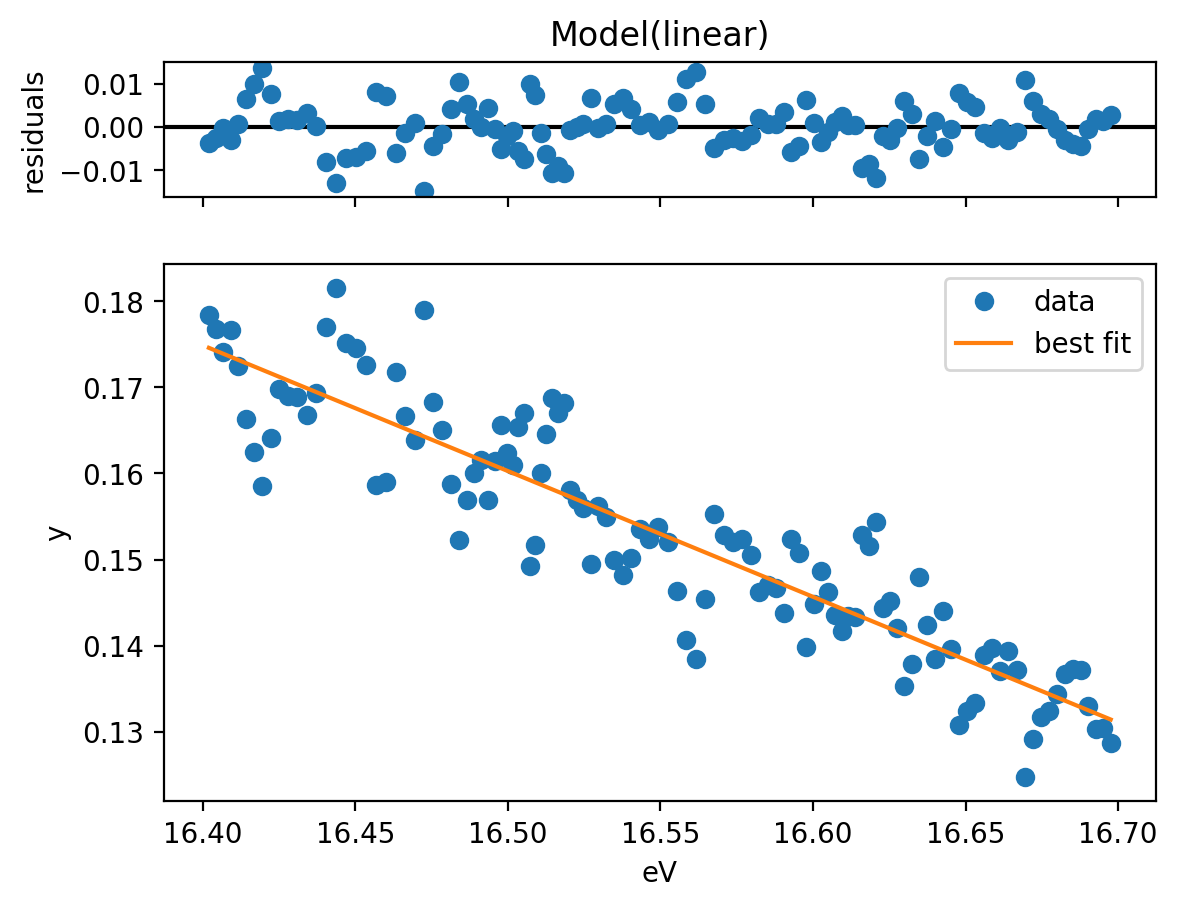

In [44]:
fit_result.plot_fit()

This method scales to higher-dimensional data as for the full fit methods:

<div class="alert alert-block alert-info"><b>Analysis info: </b> Sequential fitting only supported for 2D data. Defaulting to non-sequential. </div>

Column
    [0] Row
        [0] IntSlider(end=9, name='x2')
        [1] IntSlider(end=11, name='x1')
        [2] IntSlider(end=19, name='theta_par')
    [1] Matplotlib(Figure)
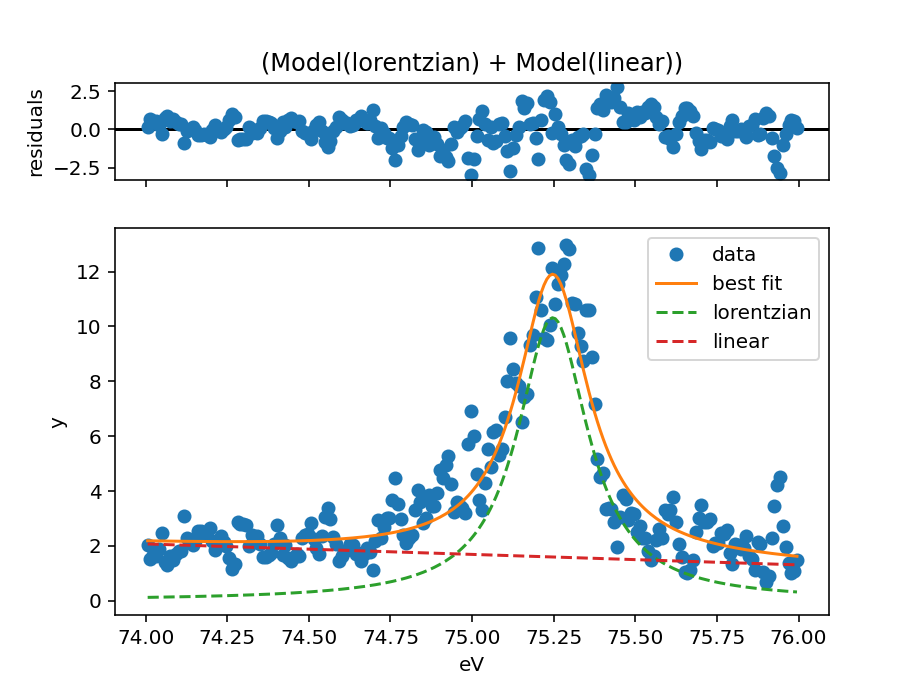

In [45]:
SM1.quick_fit.lorentzian(independent_var='eV').plot_fit()